### Load images and corresponding masks......

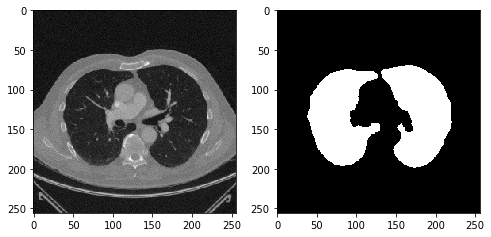

In [2]:

import os
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


def load_training_val_images_mask(dir_images,dir_mask,IMG_HEIGHT, IMG_WIDTH):
    
    all_images = [x for x in sorted(os.listdir(dir_images)) if x[-4:] == '.tif']

    x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
    for i, name in enumerate(all_images):
        im = cv2.imread(dir_images + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
        im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        x_data[i] = im

    all_masks = [x for x in sorted(os.listdir(dir_mask)) if x[-4:] == '.tif']
    y_data = np.empty((len(all_masks), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
    for i, name in enumerate(all_masks):
        im = cv2.imread(dir_mask + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
        im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        y_data[i] = im
        
    
    images = x_data
    masks = y_data
    
    return images, masks
    

IMG_HEIGHT = 256
IMG_WIDTH = 256

dir_images = 'data/2d_images/'
dir_mask = 'data/2d_masks/'
images, masks = load_training_val_images_mask(dir_images,dir_mask,IMG_HEIGHT, IMG_WIDTH)

fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(masks[0], cmap='gray')
plt.show()

### Split the images for training and validation sets and show the image detatils

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size = 0.5)


x_train = x_train.reshape(x_train.shape[0], IMG_HEIGHT, IMG_WIDTH,1)
y_train = y_train.reshape(y_train.shape[0], IMG_HEIGHT, IMG_WIDTH,1)

x_val = x_val.reshape(x_val.shape[0], IMG_HEIGHT, IMG_WIDTH,1)
y_val = y_val.reshape(y_val.shape[0], IMG_HEIGHT, IMG_WIDTH,1)

input_shape = (IMG_HEIGHT, IMG_WIDTH,1)

print x_train.shape
print y_train.shape

print x_val.shape
print y_val.shape
print input_shape

(133, 256, 256, 1)
(133, 256, 256, 1)
(134, 256, 256, 1)
(134, 256, 256, 1)
(256, 256, 1)


### Create U-Net model

In [14]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

### Call the load the model... 

In [15]:

pretrained_weights = None
model = unet(pretrained_weights,input_size = (256,256,1))
model.summary()
#adam_opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#model.compile(optimizer=adam_opt, loss='binary_crossentropy',metrics = ['accuracy', 'mse'])



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_73[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_75 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


###  Run the model


In [16]:
    
num_epochs = 5
batch_size = 8
hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_val, y_val))

model.save_weights('unet_weights.h5', overwrite=True)

Train on 133 samples, validate on 134 samples
Epoch 1/5
133/133 [==============================] - 75s 567ms/step - loss: 0.6067 - acc: 0.7708 - val_loss: 0.5501 - val_acc: 0.7586
Epoch 2/5
133/133 [==============================] - 73s 551ms/step - loss: 0.4340 - acc: 0.7708 - val_loss: 0.4448 - val_acc: 0.7586
Epoch 3/5
133/133 [==============================] - 73s 552ms/step - loss: 0.3368 - acc: 0.7708 - val_loss: 0.3311 - val_acc: 0.7586
Epoch 4/5
133/133 [==============================] - 74s 559ms/step - loss: 0.2889 - acc: 0.7708 - val_loss: 0.3158 - val_acc: 0.7586
Epoch 5/5
133/133 [==============================] - 74s 560ms/step - loss: 0.2778 - acc: 0.7750 - val_loss: 0.3316 - val_acc: 0.8144


### Show the training history

['acc', 'loss', 'val_acc', 'val_loss']


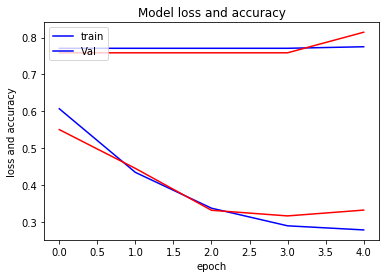

In [19]:
print hist.history.keys()

plt.plot(hist.history['acc'],color = 'b')
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.plot(hist.history['val_loss'], color='r')


plt.title('Model loss and accuracy')
plt.ylabel('loss and accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val',], loc='upper left')
#plt.savefig(img_path % 'accuracy')


plt.show()

### Test and display resutls

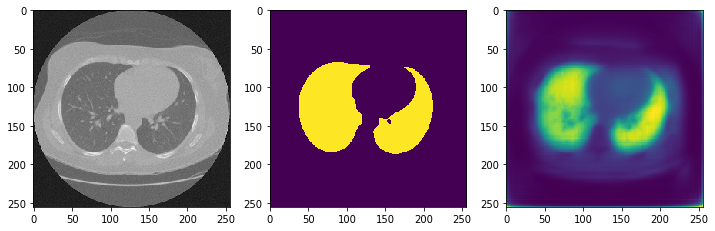

In [22]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[15,:,:,0], cmap='gray')
ax[1].imshow(y_val[15,:,:,0])
ax[2].imshow(y_hat[15,:,:,0])